In [ ]:
!pip install transformers==4.40.0

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

from transformers import logging
logging.set_verbosity_error()

import os
import time
import torch
import pandas as pd
from tqdm.auto import tqdm

# 1) Import CheXagent
from transformers import AutoTokenizer, AutoModelForCausalLM
class CheXagent:
    def __init__(self, model_name="StanfordAIMI/CheXagent-2-3b"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.dtype  = torch.bfloat16 if "cuda" in self.device else torch.float32
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        self.model     = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            trust_remote_code=True
        ).to(self.dtype).to(self.device).eval()

    def generate(self, paths, prompt):
        # build multimodal query
        q = self.tokenizer.from_list_format(
            [*({"image": p} for p in paths), {"text": prompt}]
        )
        conv = [
            {"from": "system", "value": "You are a helpful assistant."},
            {"from": "human",  "value": q},
        ]
    
        # 1) apply template → maybe a Tensor, maybe a dict
        out = self.tokenizer.apply_chat_template(
            conv, add_generation_prompt=True, return_tensors="pt"
        )
        if isinstance(out, torch.Tensor):
            input_ids = out.to(self.device)
        else:
            input_ids = out["input_ids"].to(self.device)
    
        # 2) generate
        output_ids = self.model.generate(
            input_ids,
            do_sample=False,
            num_beams=1,
            max_new_tokens=512,
            pad_token_id=self.tokenizer.eos_token_id,
            eos_token_id=self.tokenizer.eos_token_id,
        )[0]
    
        # 3) decode only the newly generated tokens
        gen = output_ids[input_ids.size(1) : ]
        response = self.tokenizer.decode(gen, skip_special_tokens=True)
        return response


    def disease_identification(self, paths, disease_list):
        prompt = "Given the CXR, identify any diseases. Options:\n" + ", ".join(disease_list)
        return self.generate(paths, prompt)


# 2) Setup paths & read GT
IMAGE_DIR = "/kaggle/input/chest-x-ray-images/test_data"
GT_CSV    = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"

gt_df = pd.read_csv(GT_CSV)
gt_df["ImageName"] = gt_df["ImageName"].apply(os.path.basename)

# 3) Define diseases & instantiate CheXagent
DISEASES = [c for c in gt_df.columns if c != "ImageName"]
agent = CheXagent()

# 4) Run inference
records = []
times = []

for img_name in tqdm(gt_df["ImageName"], desc="Inferring"):
    img_path = os.path.join(IMAGE_DIR, img_name)
    
    t0 = time.time()
    reply = agent.disease_identification([img_path], DISEASES)
    t1 = time.time()
    times.append(t1 - t0)
    
    # normalize reply and split on commas / 'and'
    tokens = [t.strip().lower() for t in reply.replace("and",",").split(",")]
    
    # build row: 1 if disease appears in tokens else 0
    row = {"ImageName": img_name}
    for d in DISEASES:
        row[d] = 1 if d.lower() in tokens else 0
    
    records.append(row)

# 5) Save predictions + timing
pred_df = pd.DataFrame(records)
pred_df["InferenceTime_s"] = times
pred_df.to_csv("chexagent_disease_id_preds.csv", index=False)

# 6) Compare to GT
merged = gt_df.merge(pred_df, on="ImageName", suffixes=("_gt","_pred"))

# compute per-condition accuracy
from sklearn.metrics import accuracy_score

accs = {}
for d in DISEASES:
    y_true = merged[f"{d}_gt"]
    y_pred = merged[f"{d}_pred"]
    accs[d] = accuracy_score(y_true, y_pred)

# overall accuracy (flatten all labels)
all_true = merged[[f"{d}_gt" for d in DISEASES]].values.flatten()
all_pred = merged[[f"{d}_pred" for d in DISEASES]].values.flatten()
overall_acc = accuracy_score(all_true, all_pred)

# 7) Print results
print(f"Overall accuracy: {overall_acc:.3f}")
print("Per-condition accuracy:")
for d, a in accs.items():
    print(f"  {d:20s}: {a:.3f}")
print(f"Average inference time per image: {sum(times)/len(times):.2f}s")


In [ ]:
# ───────────────────────────────────────────────────
# 8) Compute & plot overall confusion matrix
# ───────────────────────────────────────────────────
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten all ground truth and predicted labels
y_true = merged[[f"{d}_gt" for d in DISEASES]].values.flatten()
y_pred = merged[[f"{d}_pred" for d in DISEASES]].values.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Save as CSV
cm_df = pd.DataFrame(
    cm,
    index=["True 0","True 1"],
    columns=["Pred 0","Pred 1"]
)
cm_df.to_csv("confusion_matrix.csv", index=True)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Overall Confusion Matrix (All Labels Flattened)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ─────────────────────────────────────────────────────────────────────────────
# 1) Paths & load data
# ─────────────────────────────────────────────────────────────────────────────
GT_CSV        = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEXAGENT_CSV = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV    = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

gt_df       = pd.read_csv(GT_CSV)
gt_df["ImageName"] = gt_df["ImageName"].apply(lambda p: os.path.basename(p))

chex_df     = pd.read_csv(CHEXAGENT_CSV)
medvit_df   = pd.read_csv(MEDVIT_CSV)

# Merge predictions onto GT
chex_merged   = gt_df.merge(chex_df,   on="ImageName", suffixes=("_gt","_pred"))
medvit_merged = gt_df.merge(medvit_df, on="ImageName", suffixes=("_gt","_pred"))

# List of condition names
conditions = [c for c in gt_df.columns if c != "ImageName"]

# ─────────────────────────────────────────────────────────────────────────────
# 2) Helper to compute & plot per‐condition CM
# ─────────────────────────────────────────────────────────────────────────────
def plot_and_save_cm(y_true, y_pred, cond, out_dir):
    # compute 2×2 CM: [[TN, FP],[FN, TP]]
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    # save raw CSV
    cm_df = pd.DataFrame(cm,
                         index=["True 0","True 1"],
                         columns=["Pred 0","Pred 1"])
    os.makedirs(out_dir, exist_ok=True)
    cm_df.to_csv(os.path.join(out_dir, f"{cond}.csv"))
    
    # plot heatmap
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues",
                cbar=False, square=True)
    plt.title(f"{cond} (CM)")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{cond}.png"))
    plt.close()

# ─────────────────────────────────────────────────────────────────────────────
# 3) Generate for CheXagent
# ─────────────────────────────────────────────────────────────────────────────
chex_out = "cm_chexagent"
for cond in conditions:
    y_t = chex_merged[f"{cond}_gt"]
    y_p = chex_merged[f"{cond}_pred"]
    plot_and_save_cm(y_t, y_p, cond, chex_out)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Generate for MedViT
# ─────────────────────────────────────────────────────────────────────────────
medvit_out = "cm_medvit"
for cond in conditions:
    y_t = medvit_merged[f"{cond}_gt"]
    y_p = medvit_merged[f"{cond}_pred"]
    plot_and_save_cm(y_t, y_p, cond, medvit_out)

print("All confusion matrices computed, plotted, and saved.")  



All confusion matrices computed, plotted, and saved.


In [3]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/cm_chexagent/ (stored 0%)
  adding: kaggle/working/cm_chexagent/Infiltration.csv (deflated 20%)
  adding: kaggle/working/cm_chexagent/Edema.csv (deflated 19%)
  adding: kaggle/working/cm_chexagent/Atelectasis.png (deflated 11%)
  adding: kaggle/working/cm_chexagent/Mass.png (deflated 11%)
  adding: kaggle/working/cm_chexagent/Effusion.csv (deflated 19%)
  adding: kaggle/working/cm_chexagent/Lung Opacity.csv (deflated 20%)
  adding: kaggle/working/cm_chexagent/Nodule.png (deflated 12%)
  adding: kaggle/working/cm_chexagent/Mass.csv (deflated 20%)
  adding: kaggle/working/cm_chexagent/Pleural_Thickening.png (deflated 10%)
  adding: kaggle/working/cm_chexagent/Emphysema.csv (deflated 20%)
  adding: kaggle/working/cm_chexagent/Fibrosis.png (deflated 12%)
  adding: kaggle/working/cm_chexagent/Emphysema.png (deflated 11%)
  adding: kaggle/working/cm_chexagent/Enlarged Cardiomediastinum.png (deflated 11%)
  adding: kaggle/working/

In [4]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# 1) Load ground truth & predictions
GT_CSV        = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV      = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV    = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

gt = pd.read_csv(GT_CSV)
gt["ImageName"] = gt["ImageName"].apply(lambda p: os.path.basename(p))
conds = [c for c in gt.columns if c != "ImageName"]

chex = pd.read_csv(CHEX_CSV)
med = pd.read_csv(MEDVIT_CSV)

chex_m = gt.merge(chex, on="ImageName", suffixes=("_gt","_pred"))
med_m  = gt.merge(med,  on="ImageName", suffixes=("_gt","_pred"))

def big_cm_df(merged_df):
    """
    Returns a DataFrame of shape (4 x n_conditions):
      rows = ['TN','FP','FN','TP']
      cols = condition names
    """
    y_true = merged_df[[f"{c}_gt"   for c in conds]].values
    y_pred = merged_df[[f"{c}_pred" for c in conds]].values

    # multilabel_confusion_matrix → array (n_labels, 2, 2)
    mlcms = multilabel_confusion_matrix(y_true, y_pred)  # :contentReference[oaicite:1]{index=1}

    # Extract TN, FP, FN, TP per label
    cm_counts = {
        "TN": mlcms[:,0,0],
        "FP": mlcms[:,0,1],
        "FN": mlcms[:,1,0],
        "TP": mlcms[:,1,1],
    }
    return pd.DataFrame(cm_counts, index=conds).T

def plot_big_cm(cm_df, model_name):
    """
    Plots a 4 x n_labels heatmap and saves CSV and PNG.
    """
    out_csv = f"big_confusion_{model_name}.csv"
    out_png = f"big_confusion_{model_name}.png"

    # Save raw counts CSV
    cm_df.to_csv(out_csv)

    # Plot
    plt.figure(figsize=(18, 4))  # wide for 18 cols
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar_kws={"label": "Count"},
        linewidths=0.5
    )
    plt.title(f"{model_name}: Confusion Counts per Condition")  # :contentReference[oaicite:2]{index=2}
    plt.ylabel("Confusion Entry")
    plt.xlabel("Condition")
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()

# 2) Build & plot for CheXagent
chex_cm = big_cm_df(chex_m)
plot_big_cm(chex_cm, "CheXagent")

# 3) Build & plot for MedViT
med_cm = big_cm_df(med_m)
plot_big_cm(med_cm, "MedViT")

print("Big confusion matrices saved for both models.")


Big confusion matrices saved for both models.


## Accuracy and Recall

In [5]:
# Load the ground truth labels
import os
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score
# Define label list
LABELS = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture',
    'Lung Opacity', 'Enlarged Cardiomediastinum'
]
gt_path = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
gt_df = pd.read_csv(gt_path)
gt_df["ImageName"] = gt_df["ImageName"].apply(os.path.basename)


medvit_pred_df = pd.read_csv('/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv')

medvit_merged = gt_df.merge(medvit_pred_df, on="ImageName", suffixes=("_gt","_pred"))

# Accuracy and recall per condition
medvit_results = []

for label in LABELS:
    y_true = medvit_merged[f"{label}_gt"]
    y_pred = medvit_merged[f"{label}_pred"]
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, zero_division=0)
    medvit_results.append({
        "Condition": label,
        "MedViT_Acc": acc,
        "MedViT_Recall": rec,
        "MedViT_TruePos": ((y_true == 1) & (y_pred == 1)).sum(),
        "TotalPos": (y_true == 1).sum()
    })

medvit_results_df = pd.DataFrame(medvit_results)
medvit_results_df.to_csv("medvit7993_per_condition_metrics.csv", index=False)
medvit_results_df


,Condition,MedViT_Acc,MedViT_Recall,MedViT_TruePos,TotalPos
0,Atelectasis,0.815219,0.823102,3057,3714
1,Consolidation,0.843064,0.829254,2846,3432
2,Infiltration,0.847812,0.491803,480,976
3,Pneumothorax,0.833697,0.431967,527,1220
4,Edema,0.847171,0.749576,1766,2356
5,Emphysema,0.946234,0.462168,226,489
6,Fibrosis,0.950083,0.106195,36,339
7,Effusion,0.780187,0.776657,2695,3470
8,Pneumonia,0.819068,0.642507,1312,2042
9,Pleural_Thickening,0.849352,0.452572,563,1244


In [7]:
chex_pred_df = pd.read_csv('/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv')

chex_merged = gt_df.merge(chex_pred_df, on="ImageName", suffixes=("_gt","_pred"))

# Accuracy and recall per condition
chex_results = []

for label in LABELS:
    chex_y_true = chex_merged[f"{label}_gt"]
    chex_y_pred = chex_merged[f"{label}_pred"]
    acc = accuracy_score(chex_y_true, chex_y_pred)
    rec = recall_score(chex_y_true, chex_y_pred, zero_division=0)
    chex_results.append({
        "Condition": label,
        "ChexAgent_Acc": acc,
        "ChexAgent_Recall": rec,
        "ChexAgent_TruePos": ((chex_y_true == 1) & (chex_y_pred == 1)).sum(),
        "TotalPos": (chex_y_true == 1).sum()
    })

chex_results_df = pd.DataFrame(chex_results)
chex_results_df.to_csv("chex7993_per_condition_metrics.csv", index=False)
chex_results_df

,Condition,ChexAgent_Acc,ChexAgent_Recall,ChexAgent_TruePos,TotalPos
0,Atelectasis,0.569100,0.915724,3401,3714
1,Consolidation,0.610933,0.911131,3127,3432
2,Infiltration,0.305531,0.641393,626,976
3,Pneumothorax,0.609008,0.409836,500,1220
4,Edema,0.518414,0.140068,330,2356
5,Emphysema,0.803670,0.701431,343,489
6,Fibrosis,0.774541,0.398230,135,339
7,Effusion,0.454510,0.367435,1275,3470
8,Pneumonia,0.537020,0.214006,437,2042
9,Pleural_Thickening,0.664314,0.350482,436,1244


In [8]:
import pandas as pd

# 1. Load both CSVs
chex_df = pd.read_csv("/kaggle/working/chex7993_per_condition_metrics.csv")
medvit_df = pd.read_csv("/kaggle/working/medvit7993_per_condition_metrics.csv")

# 2. Merge on 'Condition'
merged_df = chex_df.merge(medvit_df, on="Condition", suffixes=("_CheXagent", "_MedVit"))

# 3. Save the merged result
merged_df.to_csv("merged_model_metrics_7993.csv", index=False)

# 4. Optional: display merged DataFrame
print(merged_df)


                     Condition  ChexAgent_Acc  ChexAgent_Recall  \
0                  Atelectasis       0.569100          0.915724   
1                Consolidation       0.610933          0.911131   
2                 Infiltration       0.305531          0.641393   
3                 Pneumothorax       0.609008          0.409836   
4                        Edema       0.518414          0.140068   
5                    Emphysema       0.803670          0.701431   
6                     Fibrosis       0.774541          0.398230   
7                     Effusion       0.454510          0.367435   
8                    Pneumonia       0.537020          0.214006   
9           Pleural_Thickening       0.664314          0.350482   
10                Cardiomegaly       0.409983          0.169857   
11                      Nodule       0.670089          0.633205   
12                        Mass       0.676890          0.666948   
13                      Hernia       0.688695          0.67391

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# List of pathologies (labels)
pathologies = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture',
    'Lung Opacity', 'Enlarged Cardiomediastinum'
]

# Assuming `lab_array` and `out_array` are given
# `lab_array` is the ground truth labels
# `out_array` contains predicted probabilities
y_true = lab_array  # Ground truth binary multi-label array, shape (num_samples, num_labels)
threshold = 0.5
y_pred = (out_array >= threshold).astype(int)  # Predicted binary multi-label array

# Initialize an 18x18 confusion matrix
combined_conf_matrix = np.zeros((18, 18))

# Compute confusion matrix
for i in range(y_true.shape[1]):  # Iterate over each label
    for j in range(y_true.shape[1]):  # Compare with all other labels
        if i != j:
            # Count cases where:
            # - Label i is present in ground truth
            # - Label j is mistakenly predicted
            # - Label j was not actually present in ground truth
            combined_conf_matrix[i, j] = np.sum((y_true[:, i] == 1) & (y_pred[:, j] == 1) & (y_true[:, j] == 0))
        else:
            combined_conf_matrix[i, j] =  np.sum((y_true[:, i] == 1) & (y_pred[:, j] == 1) )
            

# Plot the corrected confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(combined_conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=pathologies, yticklabels=pathologies, cbar_kws={'label': 'Count'})
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Corrected 18x18 Confusion Matrix for Multi-Label Classification')
plt.tight_layout()
plt.show()

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────────────────────────────────
# 1) Load GT & Predictions
# ───────────────────────────────────────────────────────────
GT_CSV        = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV      = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV    = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

gt_df   = pd.read_csv(GT_CSV)
gt_df["ImageName"] = gt_df["ImageName"].apply(lambda p: os.path.basename(p))

chex_df = pd.read_csv(CHEX_CSV)
med_df  = pd.read_csv(MEDVIT_CSV)

# Ensure aligned
chex = gt_df.merge(chex_df, on="ImageName", suffixes=("_gt","_pred"))
med  = gt_df.merge(med_df,  on="ImageName", suffixes=("_gt","_pred"))

# List of conditions
conds = [c for c in gt_df.columns if c!="ImageName"]

# ───────────────────────────────────────────────────────────
# 2) Cross‑label confusion matrix function
# ───────────────────────────────────────────────────────────
def cross_label_cm(y_true, y_pred):
    """
    Returns an (n_labels x n_labels) matrix M where:
      M[i,i] = # times label i was truly present AND predicted present (TP)
      M[i,j] = # times label i was truly present, label j ≠ i predicted present, and j was not actually present (confusion)
    """
    n = y_true.shape[1]
    cm = np.zeros((n,n), dtype=int)
    for i in range(n):
        for j in range(n):
            if i==j:
                # true positives
                cm[i,i] = np.sum((y_true[:,i]==1) & (y_pred[:,i]==1))
            else:
                # confusions: i present, j predicted, j absent
                cm[i,j] = np.sum(
                    (y_true[:,i]==1) &
                    (y_pred[:,j]==1) &
                    (y_true[:,j]==0)
                )
    return cm  # :contentReference[oaicite:0]{index=0}

def plot_and_save(cm, labels, model_name):
    # Save CSV
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    csv_path = f"cross_label_cm_{model_name}.csv"
    df_cm.to_csv(csv_path)

    # Plot heatmap
    plt.figure(figsize=(12,10))
    sns.heatmap(
        df_cm, annot=True, fmt="d", cmap="Reds",
        xticklabels=labels, yticklabels=labels,
        cbar_kws={"label":"Count"}
    )
    plt.title(f"{model_name} Cross‑Label Confusion Matrix")  # :contentReference[oaicite:1]{index=1}
    plt.xlabel("Predicted Condition")
    plt.ylabel("True Condition")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"cross_label_cm_{model_name}.png")
    plt.close()

# ───────────────────────────────────────────────────────────
# 3) Assemble true/pred arrays & run for both models
# ───────────────────────────────────────────────────────────
for df, name in [(chex, "CheXagent"), (med, "MedViT")]:
    # Extract numpy arrays of 0/1 ground‑truth & predictions
    y_true = df[[f"{c}_gt"   for c in conds]].values
    y_pred = df[[f"{c}_pred" for c in conds]].values

    # Cross‑label confusion matrix
    cm = cross_label_cm(y_true, y_pred)

    # Plot & save
    plot_and_save(cm, conds, name)

print("Done: cross‑label confusion matrices for CheXagent and MedViT saved.")  


Done: cross‑label confusion matrices for CheXagent and MedViT saved.


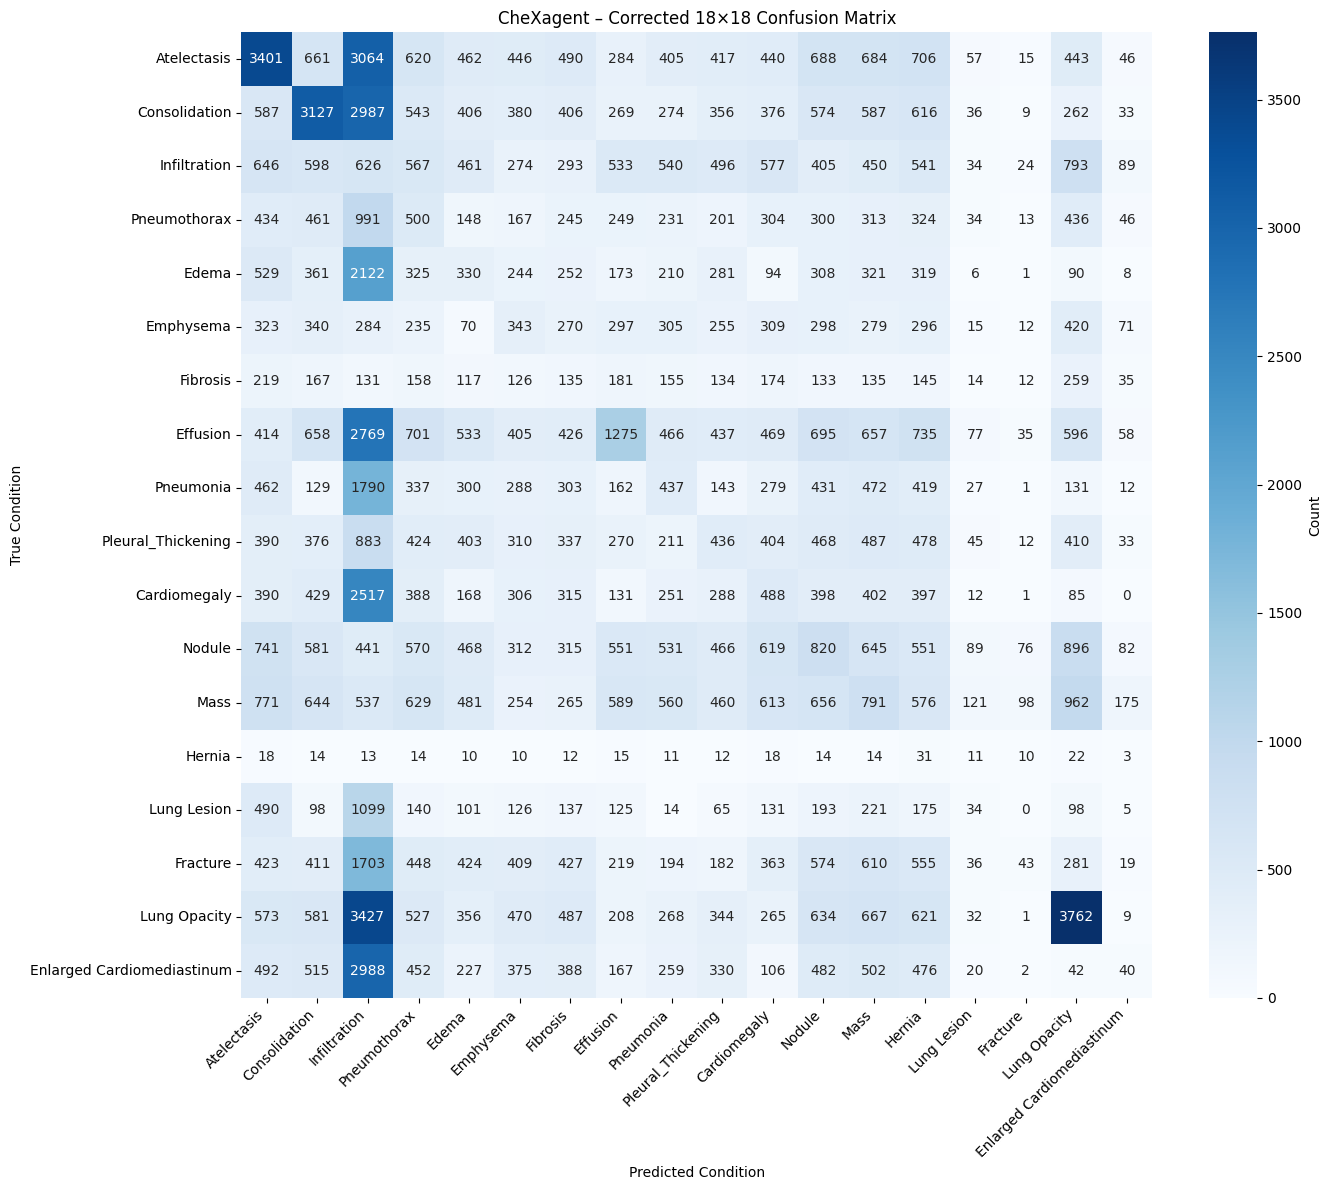

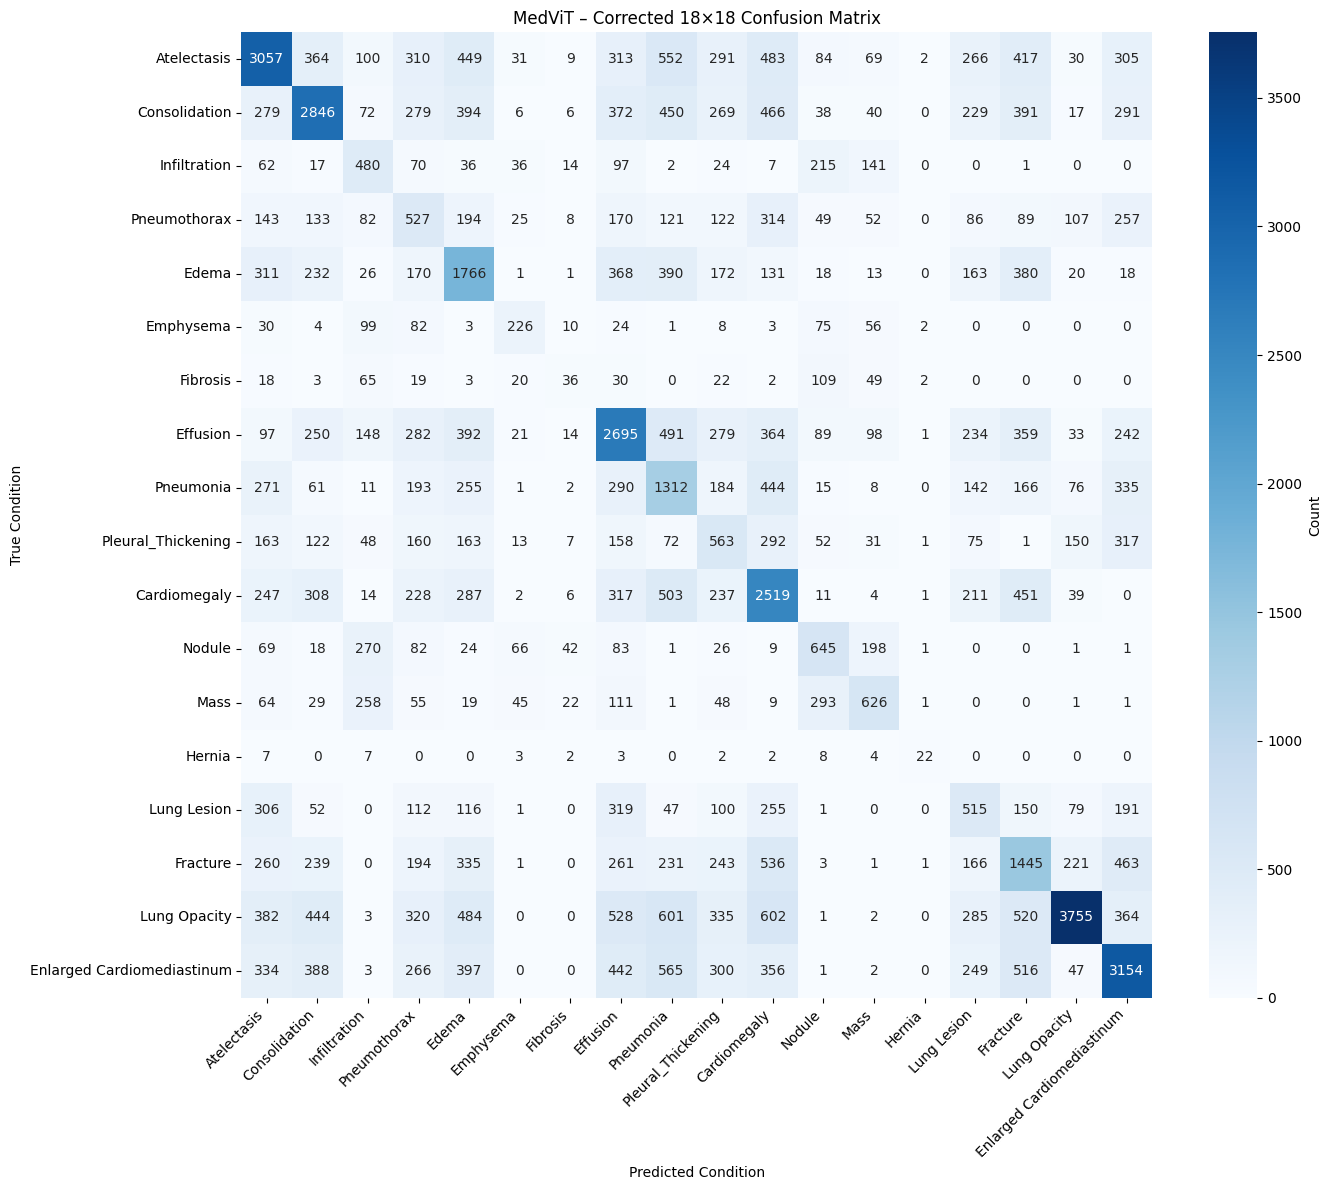

Corrected confusion matrices for both models have been saved.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Paths to your CSVs
GT_CSV        = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV      = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV    = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

# 2) Read DataFrames
gt_df   = pd.read_csv(GT_CSV)
gt_df["ImageName"] = gt_df["ImageName"].apply(os.path.basename)

chex_df = pd.read_csv(CHEX_CSV)
med_df  = pd.read_csv(MEDVIT_CSV)

# 3) Merge predictions onto GT
chex_m = gt_df.merge(chex_df, on="ImageName", suffixes=("_gt","_pred"))
med_m  = gt_df.merge(med_df,  on="ImageName", suffixes=("_gt","_pred"))

# 4) Define the 18 conditions
conditions = [c for c in gt_df.columns if c != "ImageName"]

# 5) Function to build the 18×18 corrected confusion‐style matrix
def build_corrected_cm(df, conditions):
    # extract numpy arrays
    y_true = df[[f"{c}_gt"   for c in conditions]].values
    y_pred = df[[f"{c}_pred" for c in conditions]].values

    cm = np.zeros((len(conditions), len(conditions)), dtype=int)

    for i in range(len(conditions)):
        for j in range(len(conditions)):
            if i == j:
                # true positives for condition i
                cm[i, j] = np.sum((y_true[:, i] == 1) & (y_pred[:, j] == 1))
            else:
                # model predicted j when true was i (and true j=0)
                cm[i, j] = np.sum(
                    (y_true[:, i] == 1) &
                    (y_pred[:, j] == 1) &
                    (y_true[:, j] == 0)
                )
    return cm

# 6) Function to plot & save one big matrix
def plot_corrected_cm(cm, conditions, model_name):
    df_cm = pd.DataFrame(cm, index=conditions, columns=conditions)
    # Save raw CSV
    csv_name = f"corrected_cm_{model_name}.csv"
    df_cm.to_csv(csv_name)

    # Plot
    plt.figure(figsize=(14, 12))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=conditions, yticklabels=conditions,
                cbar_kws={"label": "Count"})
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.xlabel("Predicted Condition")
    plt.ylabel("True Condition")
    plt.title(f"{model_name} – Corrected 18×18 Confusion Matrix")
    plt.tight_layout()
    png_name = f"corrected_cm_{model_name}.png"
    plt.savefig(png_name)
    plt.show()
    plt.close()

# 7) Compute and plot for CheXagent
cm_chex = build_corrected_cm(chex_m, conditions)
plot_corrected_cm(cm_chex, conditions, "CheXagent")

# 8) Compute and plot for MedViT
cm_med = build_corrected_cm(med_m, conditions)
plot_corrected_cm(cm_med, conditions, "MedViT")

print("Corrected confusion matrices for both models have been saved.")


### Fixing 18x18 matrix logic

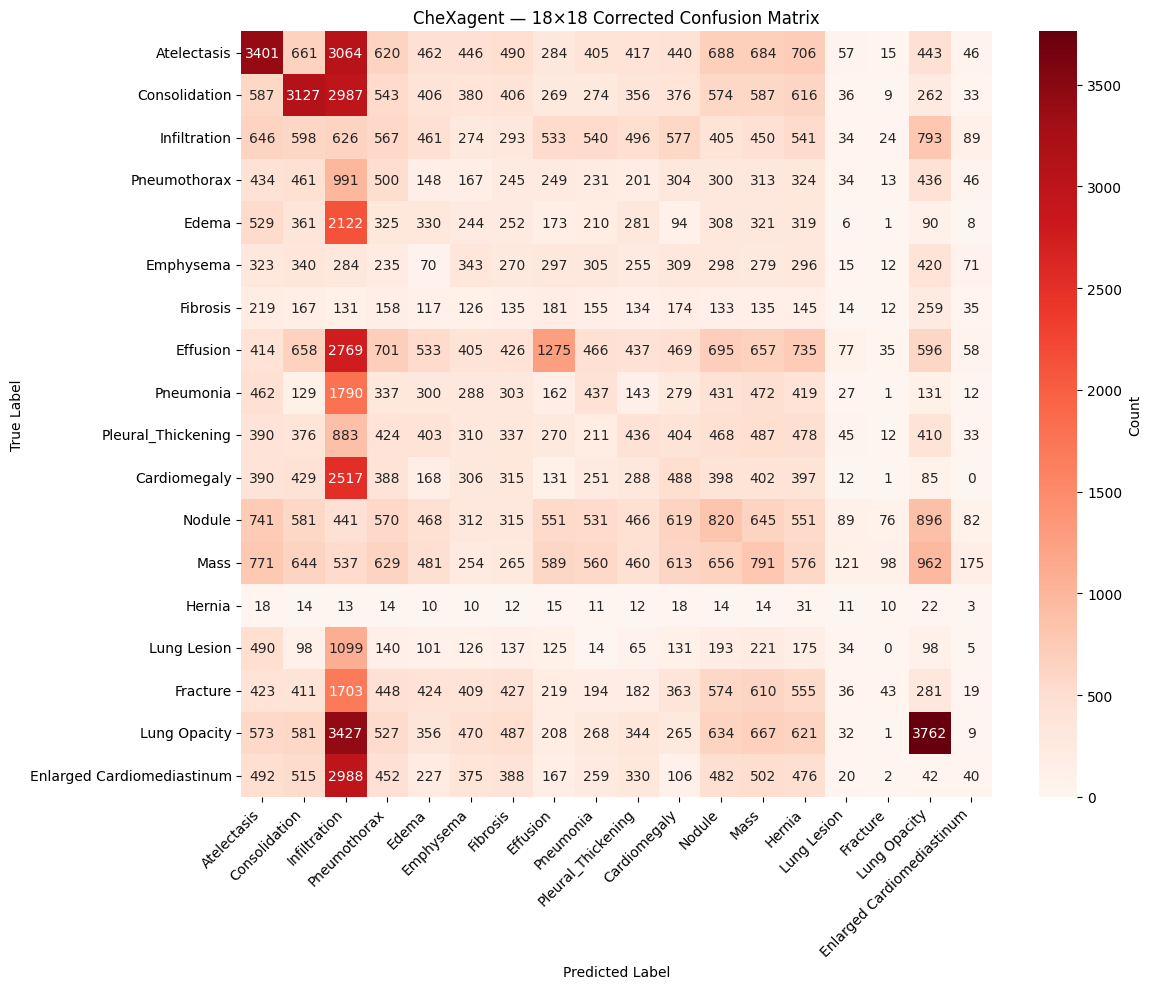

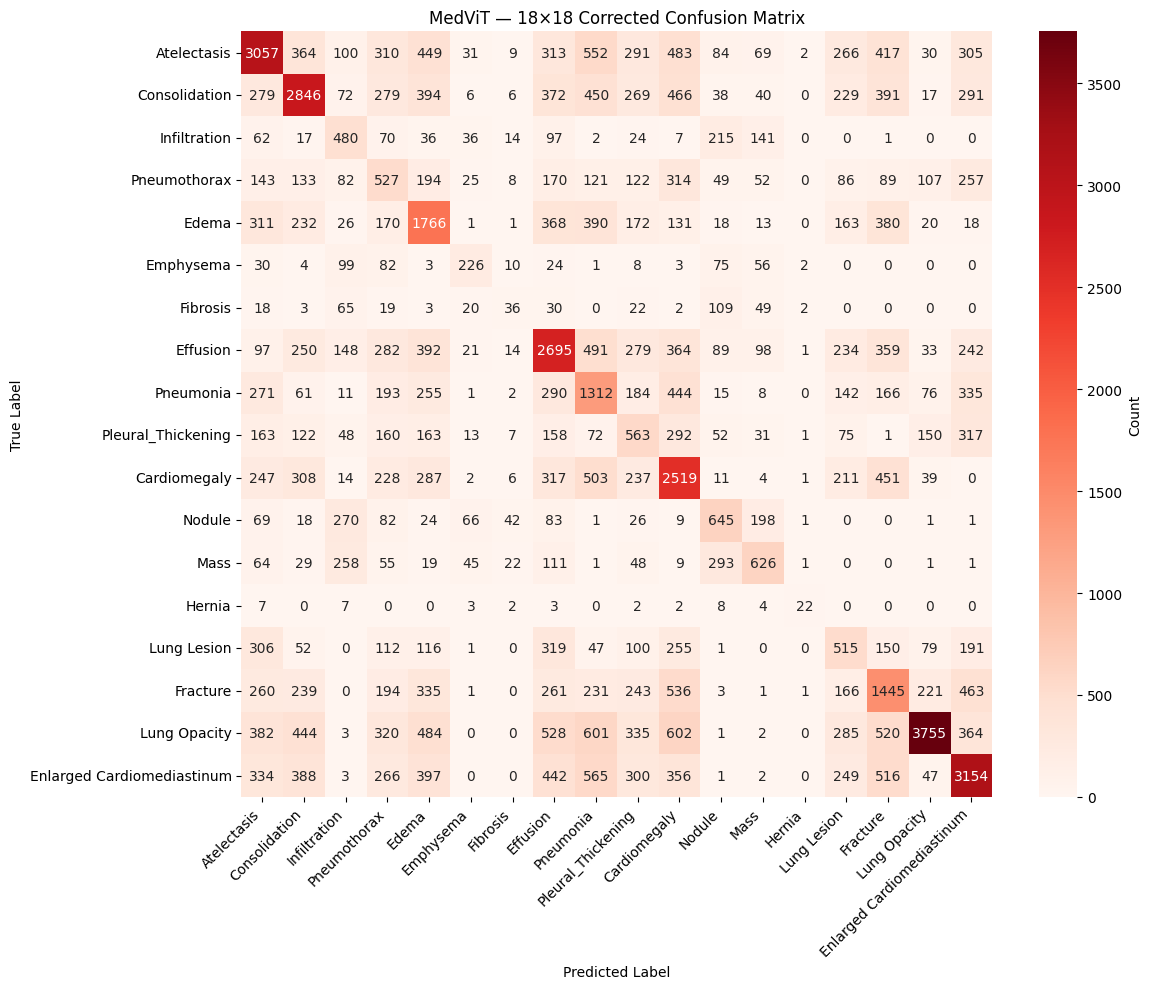

Finished building and saving 18×18 confusion matrices.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# ─────────────────────────────────────────────────────────────────────────────
# 0) Paths & label names
# ─────────────────────────────────────────────────────────────────────────────
GT_CSV        = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV      = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV    = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

labels = [
    'Atelectasis','Consolidation','Infiltration','Pneumothorax','Edema',
    'Emphysema','Fibrosis','Effusion','Pneumonia','Pleural_Thickening',
    'Cardiomegaly','Nodule','Mass','Hernia','Lung Lesion','Fracture',
    'Lung Opacity','Enlarged Cardiomediastinum'
]

# ─────────────────────────────────────────────────────────────────────────────
# 1) Load & align GT + predictions
# ─────────────────────────────────────────────────────────────────────────────
gt = pd.read_csv(GT_CSV)
gt["ImageName"] = gt["ImageName"].apply(os.path.basename)

def load_merged(pred_csv):
    preds = pd.read_csv(pred_csv)
    return gt.merge(preds, on="ImageName", suffixes=("_gt","_pred"))

chex_m = load_merged(CHEX_CSV)
med_m  = load_merged(MEDVIT_CSV)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Extract y_true, y_pred arrays
# ─────────────────────────────────────────────────────────────────────────────
def extract_arrays(df):
    y_true = df[[f"{c}_gt"   for c in labels]].values
    y_pred = df[[f"{c}_pred" for c in labels]].values
    return y_true, y_pred

# ─────────────────────────────────────────────────────────────────────────────
# 3) Compute corrected 18×18 matrix
# ─────────────────────────────────────────────────────────────────────────────
def corrected_matrix(y_true, y_pred):
    n = y_true.shape[1]
    # get per-label 2×2 confusion matrices
    mlcms = multilabel_confusion_matrix(y_true, y_pred)
    cm = np.zeros((n, n), dtype=int)
    for i in range(n):
        # diagonal = TP for label i
        cm[i, i] = int(mlcms[i,1,1])
        for j in range(n):
            if i == j:
                continue
            # among samples where i is true & j is false, count preds of j
            mask = (y_true[:,i] == 1) & (y_true[:,j] == 0)
            cm[i, j] = int(np.sum(y_pred[mask, j] == 1))
    return cm

# ─────────────────────────────────────────────────────────────────────────────
# 4) Plot & save heatmap
# ─────────────────────────────────────────────────────────────────────────────
def plot_cm(cm, model_name):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    # save CSV
    df_cm.to_csv(f"corrected_cm_{model_name}.csv")
    # plot
    plt.figure(figsize=(12,10))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Reds",
                xticklabels=labels, yticklabels=labels,
                cbar_kws={"label":"Count"})
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} — 18×18 Corrected Confusion Matrix")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"corrected_cm_{model_name}.png")
    plt.close()

# ─────────────────────────────────────────────────────────────────────────────
# 5) Run for both models
# ─────────────────────────────────────────────────────────────────────────────
for model_name, df in [("CheXagent", chex_m), ("MedViT", med_m)]:
    y_t, y_p = extract_arrays(df)
    cm       = corrected_matrix(y_t, y_p)
    plot_cm(cm, model_name)

print("Finished building and saving 18×18 confusion matrices.")


## Custom Multi-label confusion matrix

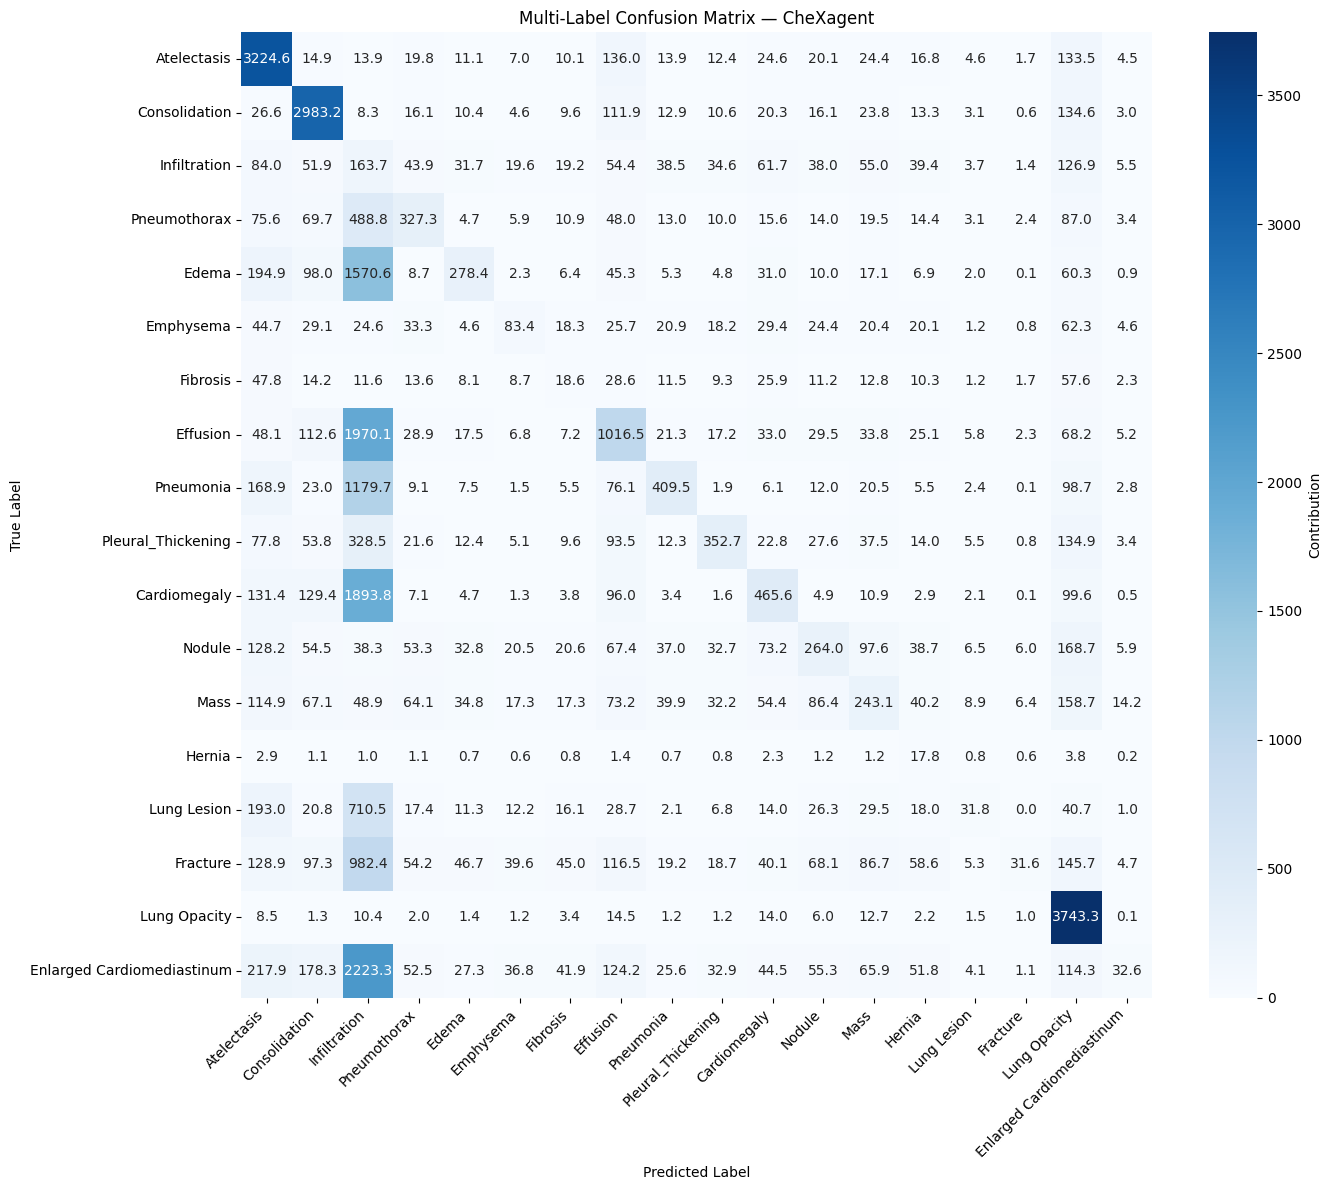

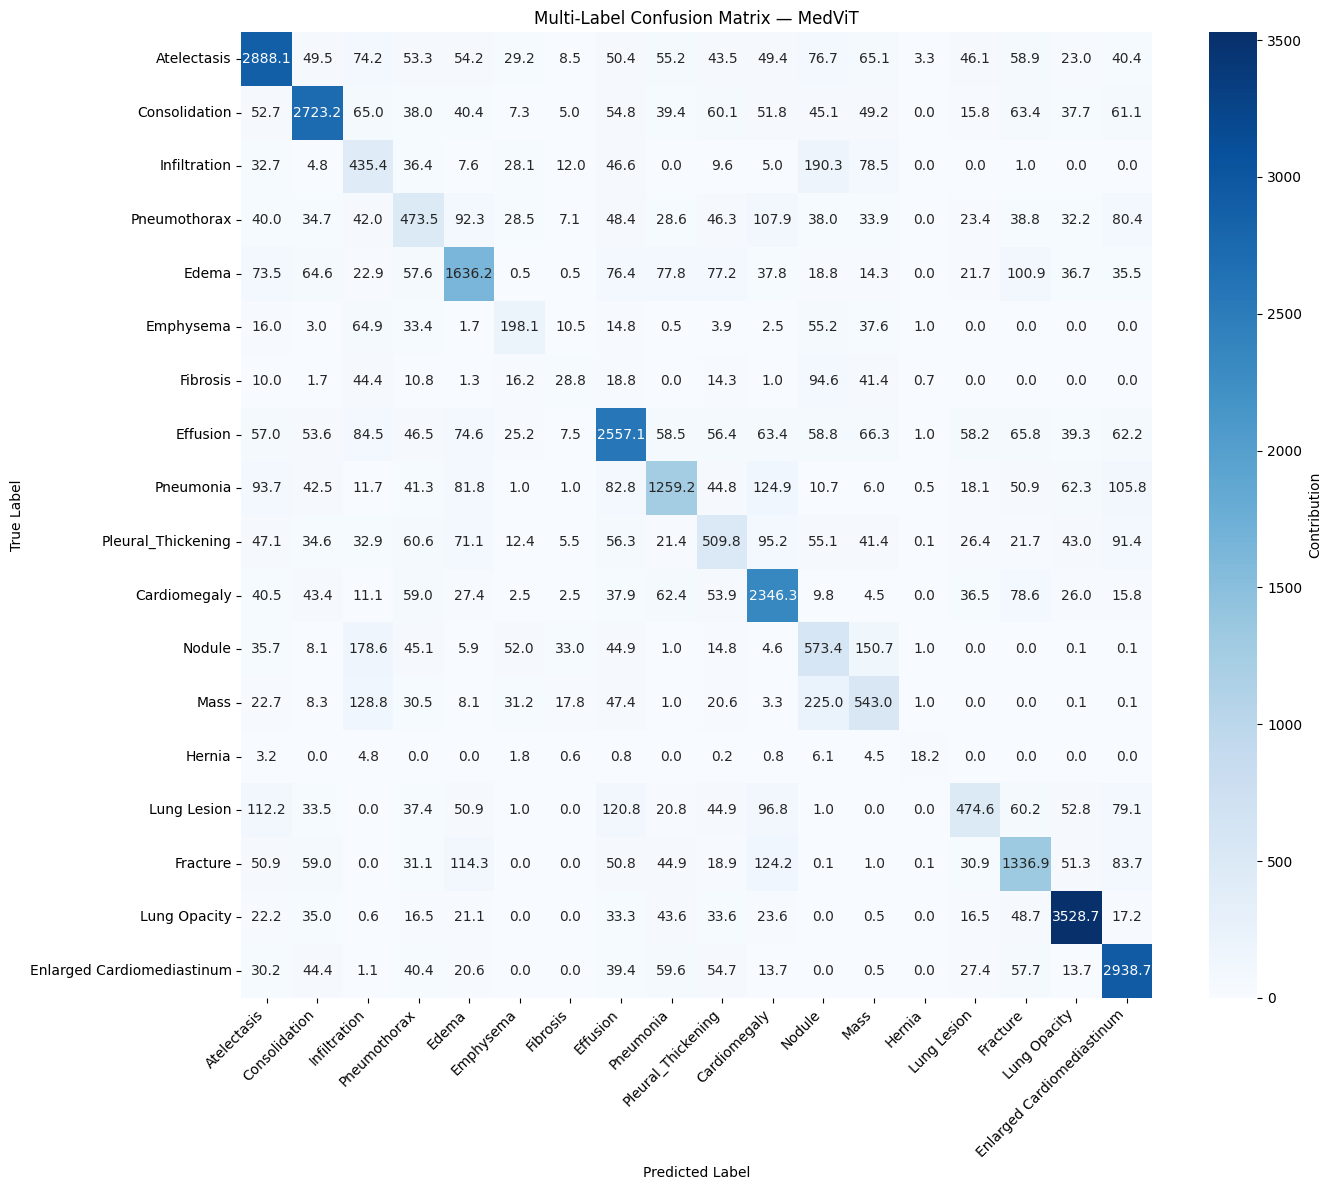

In [3]:
import os
import numpy  as np
import pandas as pd

# 1) Filepaths
GT_CSV      = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV    = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV  = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

LABELS = [
  'Atelectasis','Consolidation','Infiltration','Pneumothorax','Edema',
  'Emphysema','Fibrosis','Effusion','Pneumonia','Pleural_Thickening',
  'Cardiomegaly','Nodule','Mass','Hernia','Lung Lesion','Fracture',
  'Lung Opacity','Enlarged Cardiomediastinum'
]

# 2) Load ground truth
gt = pd.read_csv(GT_CSV)
gt["ImageName"] = gt["ImageName"].apply(os.path.basename)

def merged_df(pred_csv):
    preds = pd.read_csv(pred_csv)
    return gt.merge(preds, on="ImageName", suffixes=("_gt","_pred"))

dfs = {
    "CheXagent": merged_df(CHEX_CSV),
    "MedViT":    merged_df(MEDVIT_CSV)
}

# 3) Algorithm 1: per-image contribution C
def per_image_contribution(y_gt, y_pr):
    Y = y_gt.astype(int)
    Z = y_pr.astype(int)
    idx_true  = np.where(Y==1)[0]
    idx_pred  = np.where(Z==1)[0]
    C = np.zeros((len(LABELS), len(LABELS)), dtype=float)

    # exact match
    if set(idx_true) == set(idx_pred):
        for k in idx_true:
            C[k,k] = 1.0
        return C

    Yset, Zset = set(idx_true), set(idx_pred)
    only_true = np.array(sorted(Yset - Zset), dtype=int)
    only_pred = np.array(sorted(Zset - Yset), dtype=int)
    both      = np.array(sorted(Yset & Zset),   dtype=int)

    # over‑prediction: Y ⊆ Z, extras exist
    if Yset.issubset(Zset):
        # eq (13)
        outer = np.outer(Y, [(j in only_pred) for j in range(len(LABELS))])
        C += outer * 1.0
        for k in idx_true:
            C[k,k] += len(idx_true)
        C /= len(idx_pred)
        return C

    # under‑prediction: Z ⊆ Y, misses exist
    if Zset.issubset(Yset):
        # eq (15)
        outer = np.outer([(i in only_true) for i in range(len(LABELS))], Z)
        C += outer / max(len(idx_pred), 1)
        for k in idx_pred:
            C[k,k] += 1.0
        return C

    # mixed errors: both extras & misses
    if only_true.size>0 and only_pred.size>0:
        outer = np.outer(
            [(i in only_true) for i in range(len(LABELS))],
            [(j in only_pred) for j in range(len(LABELS))]
        )
        C += outer / only_pred.size
    # diag of correct overlaps
    for k in both:
        C[k,k] += 1.0

    return C

# 4) Build the global 18×18 matrix
def build_confusion_matrix(df):
    M = np.zeros((len(LABELS), len(LABELS)), dtype=float)
    for _, row in df.iterrows():
        y_gt = row[[f"{l}_gt"   for l in LABELS]].values
        y_pr = row[[f"{l}_pred" for l in LABELS]].values
        M   += per_image_contribution(y_gt, y_pr)
    return pd.DataFrame(M, index=LABELS, columns=LABELS)

# 5) Compute & save for each model
import matplotlib.pyplot as plt
import seaborn as sns

for name, df in dfs.items():
    cm = build_confusion_matrix(df)
    cm.to_csv(f"mlc_confusion_{name}.csv")

    plt.figure(figsize=(14,12))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=LABELS, yticklabels=LABELS,
                cbar_kws={"label":"Contribution"})
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title(f"Multi‑Label Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"mlc_confusion_{name}.png")
    plt.close()


In [ ]:
import os
import numpy as np
import pandas as pd

# ─────────────────────────────────────────────────────────────────────────────
# 0) Paths & Labels
# ─────────────────────────────────────────────────────────────────────────────
GT_CSV      = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV    = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV  = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

LABELS = [
    'Atelectasis','Consolidation','Infiltration','Pneumothorax','Edema',
    'Emphysema','Fibrosis','Effusion','Pneumonia','Pleural_Thickening',
    'Cardiomegaly','Nodule','Mass','Hernia','Lung Lesion','Fracture',
    'Lung Opacity','Enlarged Cardiomediastinum'
]

# ─────────────────────────────────────────────────────────────────────────────
# Load & merge Prediction with Ground Truth
# ─────────────────────────────────────────────────────────────────────────────
gt = pd.read_csv(GT_CSV)
gt["ImageName"] = gt["ImageName"].apply(os.path.basename)

def load_merged(pred_csv):
    preds = pd.read_csv(pred_csv)
    return gt.merge(preds, on="ImageName", suffixes=("_gt","_pred"))

dfs = {
    "CheXagent": load_merged(CHEX_CSV),
    "MedViT":    load_merged(MEDVIT_CSV)
}

def extract_arrays(df):
    y_true = df[[f"{c}_gt"   for c in LABELS]].values.astype(int)
    y_pred = df[[f"{c}_pred" for c in LABELS]].values.astype(int)
    return y_true, y_pred


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Krstinić et al. Scenario-Based MLCM + FN/FP/Recall/Precision
# ─────────────────────────────────────────────────────────────────────────────
def per_image_C_krstinic(y_gt, y_pr):
    Y = y_gt; Z = y_pr
    idx_t, idx_p = set(np.where(Y==1)[0]), set(np.where(Z==1)[0])
    C = np.zeros((len(LABELS), len(LABELS)), dtype=float)
    # Exact match
    if idx_t == idx_p:
        for k in idx_t:
            C[k,k] = 1.0
        return C
    # Over
    if idx_t.issubset(idx_p):
        only_pred = np.array(sorted(idx_p - idx_t), dtype=int)
        for i in idx_t:
            C[i,i] += len(idx_t)
        outer = np.outer([1 if i in idx_t else 0 for i in range(len(LABELS))],
                         [1 if j in only_pred else 0 for j in range(len(LABELS))])
        C += outer
        C /= len(idx_p)
        return C
    # Under
    if idx_p.issubset(idx_t):
        only_true = np.array(sorted(idx_t - idx_p), dtype=int)
        for i in idx_p:
            C[i,i] += 1.0
        outer = np.outer([1 if i in only_true else 0 for i in range(len(LABELS))],
                         [1 if j in idx_p else 0 for j in range(len(LABELS))])
        C += outer / max(len(idx_p),1)
        return C
    # Mixed
    only_true = np.array(sorted(idx_t - idx_p), dtype=int)
    only_pred = np.array(sorted(idx_p - idx_t), dtype=int)
    # diag for correct overlaps
    for i in idx_t & idx_p:
        C[i,i] += 1.0
    if len(only_pred)>0:
        outer = np.outer([1 if i in only_true else 0 for i in range(len(LABELS))],
                         [1 if j in only_pred else 0 for j in range(len(LABELS))])
        C += outer / len(only_pred)
    return C

def build_krstinic_M(dfs):
    out = {}
    for name, df in dfs.items():
        y_t, y_p = extract_arrays(df)
        M = np.zeros((len(LABELS), len(LABELS)), dtype=float)
        for i in range(len(y_t)):
            M += per_image_C_krstinic(y_t[i], y_p[i])
        # Convert to DataFrame
        dfM = pd.DataFrame(M, index=LABELS, columns=LABELS)
        # Add FN, Recall columns
        FN = dfM.sum(axis=1) - np.diag(dfM)
        Recall = np.diag(dfM) / np.where(dfM.sum(axis=1)>0, dfM.sum(axis=1), 1)
        dfM["FalseNeg"] = FN
        dfM["Recall"]   = Recall
        # Add FP, Precision rows
        FP = dfM.sum(axis=0) - dfM.values.diagonal()
        Prec = np.diag(dfM) / np.where(dfM.sum(axis=0)>0, dfM.sum(axis=0), 1)
        dfM.loc["FalsePos"]  = list(FP) + [np.nan, np.nan]
        dfM.loc["Precision"] = list(Prec) + [np.nan, np.nan]
        out[name] = dfM
    return out


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Heydarian et al. MLCM with NTL/NPL
# ─────────────────────────────────────────────────────────────────────────────
def per_image_C_heydarian(y_gt, y_pr):
    Y = y_gt; Z = y_pr
    idx_t, idx_p = set(np.where(Y==1)[0]), set(np.where(Z==1)[0])
    n = len(LABELS)
    C = np.zeros((n+1, n+1), dtype=float)  # +1 for NPL col, +1 for NTL row
    # C1: correct diag
    for k in idx_t & idx_p:
        C[k,k] += 1
    # pure hallucination
    if len(idx_t)==0 and len(idx_p)>0:
        for j in idx_p:
            C[n, j] += 1  # NTL row
        return C
    # Cat I: under-prediction only (P⊆T)
    if idx_p.issubset(idx_t) and len(idx_t-idx_p)>0:
        for r in idx_t-idx_p:
            C[r, n] += 1   # NPL col
        return C
    # Cat II: over-prediction only (T⊆P)
    if idx_t.issubset(idx_p) and len(idx_p-idx_t)>0:
        for i in idx_t:
            for j in idx_p-idx_t:
                C[i, j] += 1
        return C
    # Mixed
    for i in idx_t-idx_p:
        for j in idx_p-idx_t:
            C[i, j] += 1
    return C

def build_heydarian_M(dfs):
    out = {}
    for name, df in dfs.items():
        y_t, y_p = extract_arrays(df)
        M = np.zeros((len(LABELS)+1, len(LABELS)+1), dtype=float)
        for i in range(len(y_t)):
            M += per_image_C_heydarian(y_t[i], y_p[i])
        cols = LABELS + ["NPL"]
        idxs = LABELS + ["NTL"]
        out[name] = pd.DataFrame(M, index=idxs, columns=cols)
    return out


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 4) Run & Inspect
# ─────────────────────────────────────────────────────────────────────────────
krst = build_krstinic_M(dfs)
hey  = build_heydarian_M(dfs)

# Example: print CheXagent’s Krstinić matrix
print("=== CheXagent: Krstinić MLCM ===")
print(krst["CheXagent"].round(2))

print("\n=== CheXagent: Heydarian MLCM ===")
print(hey["CheXagent"].round(2))

# Same for MedViT...
